Note: I built this from scratch. For V1, I borrowed concepts from the tutorial for speed.

Goal of project:

1.Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

Note: for those first two steps don’t forget to normalize your features and randomize a selection for training and testing.

2.Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Estimate a bounding box for vehicles detected.

In [432]:
# import useful libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.metrics import recall_score,precision_score,f1_score

from PIL import Image

import os

# utilities libraries
import random

%matplotlib inline

#1. Feature extraction - use histogram of oriented gradients on images
#2. Split into train and test set
#3. Then train linear svm classifier

In [412]:
# create helper functions

# 1. Function that returns HOG Features

# params are : num_blocks, cells_per_block, orientation_bins
def get_hog_features(img,orient=9, pix_per_cell=8, cell_per_block=2,vis=True, feature_vec=True):
    
    if vis:
        features, hog_image = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell,pix_per_cell),
        cells_per_block = (cell_per_block,cell_per_block), transform_sqrt=False,
        visualise = True, feature_vector = feature_vec)
        
        return features,hog_image
    else:
        features = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell,pix_per_cell),
        cells_per_block = (cell_per_block,cell_per_block), transform_sqrt=False,
        visualise = False, feature_vector = feature_vec)
        
        return features

# 2. Function that iterates through images and calls a feature extractor
# feature_params can be a bunch of params
def get_features(img_list,feature_type,feature_params,hog_channel = 0,num_samples = -99):
    
    features_list=[]
    
    #if feature_type == 'hog' and feature_params['vis'] == False:
    if feature_type == 'hog':
        for counter,img in enumerate(img_list):
            
                img = mpimg.imread(img)
                gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
                
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(img.shape[2]):
                        hog_features.append(get_hog_features(img[:,:,channel], 
                                                    feature_params['orient'], feature_params['pix_per_cell'],
                                                    feature_params['cell_per_block'], vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
                    features_list.append(hog_features)
                else:                
                    feature = get_hog_features(gray,**feature_params)
                    features_list.append(feature)
                
                if counter == num_samples:
                    print("files processed: ",counter)
                    return features_list

        return features_list


In [400]:
# file utilities

def get_files(dir_path):
    files = []
    
    for file_name in os.listdir(dir_path):
        if file_name[-3:] =='png':
            files.append(dir_path+file_name)

    return files

def plot_single_images(cur_img_np,cur_img_features):

    # cur_img_np = numpy array of image
    
    fig = plt.figure(figsize=(10, 10))
    plt_n_rows = 1
    counter = 0

    # plot original image
    ## num rows, num cols, plotnumber
    plt.subplot(plt_n_rows,3,1+counter*3)
    plt.imshow(cur_img_np)

    # plot gray image
    gray = cv2.cvtColor(cur_img_np,cv2.COLOR_RGB2GRAY)
    plt.subplot(plt_n_rows,3,2+counter*3)
    plt.imshow(gray, cmap='gray')

    # plot features
    plt.subplot(plt_n_rows,3,3+counter*3)
    plt.imshow(cur_img_features, cmap='gray')

def plot_sample_images(rand_nums,cur_img_files,cur_img_features):

    cur_files = cur_img_files
    cur_features = cur_img_features

    for counter,num in enumerate(rand_nums):
        index = num

        fig = plt.figure(figsize=(10, 10))

        # plot original image
        img = mpimg.imread(cur_files[index])
        ## num rows, num cols, plotnumber
        plt.subplot(len(rand_nums),3,1+counter*3)
        plt.imshow(img)

        # plot gray image
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        plt.subplot(len(rand_nums),3,2+counter*3)
        plt.imshow(gray, cmap='gray')

        # plot features
        plt.subplot(len(rand_nums),3,3+counter*3)
        plt.imshow(cur_features[index][1], cmap='gray')
        
def plot_sample_raw_images(rand_nums,cur_img_files):

    cur_files = cur_img_files
    fig, axs = plt.subplots(len(rand_nums)//(len(rand_nums)//4),len(rand_nums)//4, figsize=(16,8 ))
    #fig.subplots_adjust(hspace = .05, wspace=.001)
    axs = axs.ravel()

    for counter,num in enumerate(rand_nums):
        index = num
        
        # plot original image
        img = mpimg.imread(cur_files[index])
        ## num rows, num cols, plotnumber
        #plt.subplot(len(rand_nums)//2,len(rand_nums)//2,counter+1)
        axs[counter].imshow(img)

In [315]:
# get training images
car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')

In [319]:
print(len(car_images))
print(len(noncar_images))
print(car_images[0])

8792
8968
data/vehicles/GTI_Far/image0000.png


In [430]:
# Main function call

# 1. Generate list of car vs non car - Done
dir_name = '/Users/davidwoo/Documents/Projects/kitt-playlabs/udacity/CarND-Vehicle-Detection-master/data/'

folder_name_noncar = 'non-vehicles/GTI/'
folder_name_car = 'vehicles/KITTI_extracted/'


#car_files = get_files(dir_name + folder_name_car)
#noncar_files = get_files(dir_name + folder_name_noncar)

car_files = glob.glob('data/vehicles/**/*.png')
noncar_files = glob.glob('data/non-vehicles/**/*.png')


num_samples = -99

print("num car pictures ",len(car_files))
print("num car pictures ",len(noncar_files))
    

# get files in 

# 2. Set params of hog features
bog_params = {'orient' : 9,
'pix_per_cell' : 8,
'cell_per_block' : 2,
'vis':False}

hog_channel = 'ALL'
#hog_channel = 0

# 3. Generate list of features for car vs non car
car_features= get_features(car_files,'hog',bog_params,hog_channel,num_samples)
non_car_features= get_features(noncar_files,'hog',bog_params,hog_channel,num_samples)


('num car pictures ', 8792)
('num car pictures ', 8968)


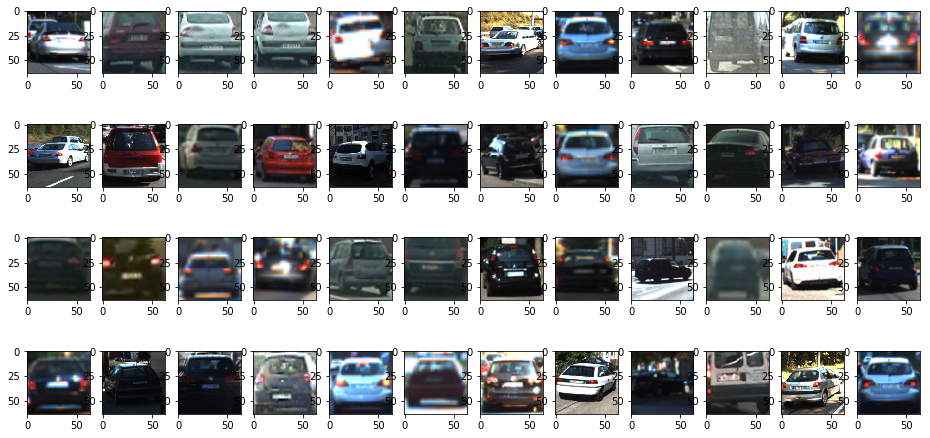

In [401]:
# plot car images then plot non car images.
rand_nums = random.sample(range(0,len(car_files)),48)

plot_sample_raw_images(rand_nums,car_files)

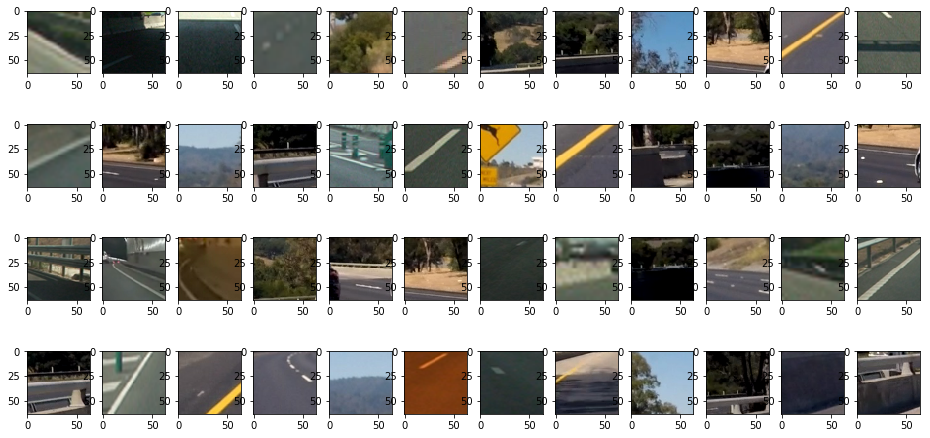

In [402]:
# plot car images then plot non car images.
rand_nums = random.sample(range(0,len(noncar_files)),48)

plot_sample_raw_images(rand_nums,noncar_files)

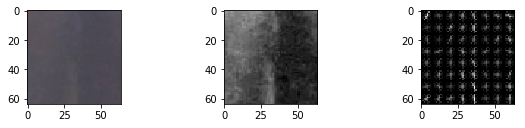

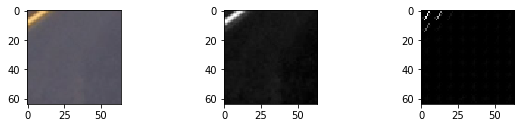

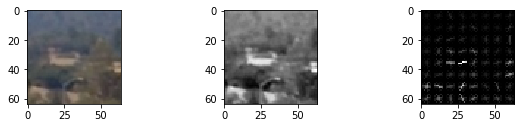

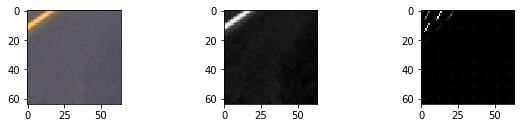

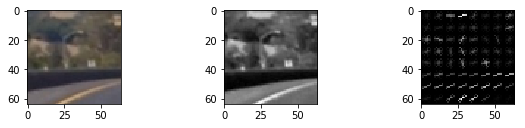

In [328]:
rand_nums = random.sample(range(0,len(car_features)),5)

cur_files = noncar_files
cur_features = non_car_features

plot_sample_images(rand_nums,cur_files,cur_features)

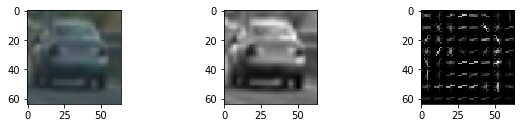

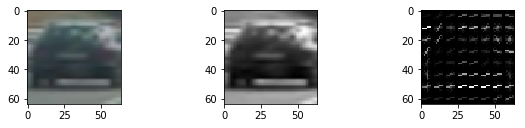

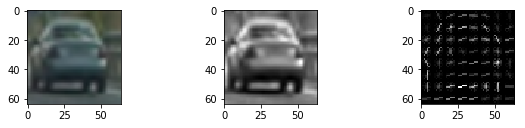

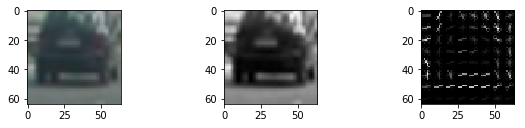

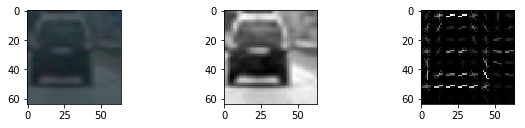

In [327]:
rand_nums = random.sample(range(0,len(car_features)),5)

cur_files = car_files
cur_features = car_features

plot_sample_images(rand_nums,cur_files,cur_features)

In [ ]:
# want to be able to visualize this. i think it's not discriminate enough between the two

index = random.sample(range(0,len(car_features)),5)[0]
plt.subplot(2,2,1)
# get one car image and plot on a graph. do a regular bar chart

plt_cols = 3
plt_rows = 2

# car 
## plot image
plt.subplot(plt_rows,plt_cols,1)
img = mpimg.imread(car_files[index])
plt.imshow(img)

## plot img features
plt.subplot(plt_rows,plt_cols,2)
plt.imshow(car_features[index][1], cmap='gray')
        
## plot img features
plt.subplot(plt_rows,plt_cols,3)
car_img_features = car_features[index][0]
y_pos = np.arange(len(car_img_features))
plt.bar(y_pos-0.01,car_img_features,color='b',align='center')

# noncar 
## plot image
plt.subplot(plt_rows,plt_cols,4)
img = mpimg.imread(noncar_files[index])
plt.imshow(img)

## plot img features
plt.subplot(plt_rows,plt_cols,5)
plt.imshow(non_car_features[index][1], cmap='gray')

## plot img features
plt.subplot(plt_rows,plt_cols,6)
non_car_img_features = non_car_features[index][0]
y_pos = np.arange(len(non_car_img_features))
plt.bar(y_pos+0.01,non_car_img_features,color='r',align='center')

#print(img_features)


In [431]:
# 4. normalize feature set
car_features_np = np.array(car_features)
print("num car pictures and features: ",car_features_np.shape)

non_car_features_np = np.array(non_car_features)
print("num car pictures and features: ",non_car_features_np.shape)

##stack car and noncar features
combined_features_np = np.vstack([car_features_np,non_car_features_np])
print("num combined pictures and features: ",combined_features_np.shape)
print(np.min(combined_features_np),np.max(combined_features_np),np.mean(combined_features_np))

## scaling similar to model
scaler = StandardScaler().fit(combined_features_np)
combined_features_np_scaled = scaler.transform(combined_features_np)
print("num combined pictures and features after scaling: ",combined_features_np_scaled.shape)
## seems to center at zero
print(np.min(combined_features_np_scaled),np.max(combined_features_np_scaled),np.mean(combined_features_np_scaled))

# 5. create labels - nicely done here.
## first x = car , botton x = noncar
labels_car = np.ones(car_features_np.shape[0])
labels_non_car = np.zeros(non_car_features_np.shape[0])
labels = np.hstack([labels_car,labels_non_car])
print(labels.shape)


# 6. split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    combined_features_np, labels, test_size=0.33, random_state=42)
print("train set x, y:",len(X_train),len(y_train))
print("test set x, y:",len(X_test),len(y_test))

# 7. train svm model
# initial SVM with params
# specify kernel ( linear, non linear), narrow or wide margin, number of samples of points
clf = LinearSVC()
clf.fit(X_train,y_train)
# this prints accuray. so 13% which seems low
print("mean accuracy",clf.score(X_test,y_test))

print("recall score" ,recall_score(y_test,clf.predict(X_test)))
print("precision score" ,precision_score(y_test,clf.predict(X_test)))
# this is a weighted average of the recall and precision so should be in between
print("f1score score" ,f1_score(y_test,clf.predict(X_test)))

# 8. output results

('num car pictures and features: ', (8792, 5292))
('num car pictures and features: ', (8968, 5292))
('num combined pictures and features: ', (17760, 5292))
(0.0, 0.99812765008961057, 0.027736194385423456)
('num combined pictures and features after scaling: ', (17760, 5292))
(-1.1621802966827575, 54.248274775514389, -9.6387314171300154e-17)
(17760,)
('train set x, y:', 11899, 11899)
('test set x, y:', 5861, 5861)
('mean accuracy', 0.97287152363077978)
('recall score', 0.97159681330100456)
('precision score', 0.97328244274809161)
('f1score score', 0.97243889755590229)


In [437]:
s = pickle.dump(clf,open("model_hog_3_channel.p","wb"))

2. Add Sliding Window

In [139]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

resized image
('hog_features shape', (66, 119, 2, 2, 9))
('image shape', (540, 960, 3))
('num slide windows x y', 29, 15)


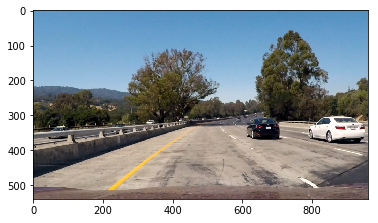

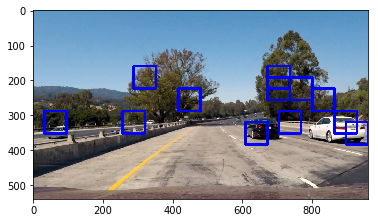

In [485]:
## version with bounding boxes only
# expected:
# https://docs.google.com/spreadsheets/d/14Wjri_t-QfGFRjHzzpbpbUJPFKOX3dT93hAW0TDz0J0/edit#gid=0

def find_cars(img,search_win_size,search_win_overlap,hog_params,y_start_stop=[None,None],x_start_stop=[None,None]):
    
    windows = []
    
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    
    #1. Subset image. Use region of interest to filter regions likely to have cars.
    img_filter = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1],:]
    
     #2. Transform RGB to greyscale. naive first
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img = img
       
    #4. Get hog features for entire image. Call get_features. cells per block need to be proportional to window
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img_filter.shape[2]):
            hog_features.append(get_hog_features(img_filter[:,:,channel], 
                                        feature_params['orient'], feature_params['pix_per_cell'],
                                        feature_params['cell_per_block'], vis=False, feature_vec=False))
        #hog_features = np.ravel(hog_features)
        print("hog_features shape",hog_features[0].shape )
    else:
        hog_features = get_hog_features(gray,**hog_params)
        print("hog_features shape",hog_features.shape )
    
    if hog_params['vis']:
        hog_features_viz = hog_features[1]
        hog_features = hog_features[0]
        print("hog_features_viz shape",hog_features_viz.shape )
        
    #print("hog_features shape",hog_features.shape )
    print("image shape",img.shape )
    
    #5. Slide sliding window across the image 
    ##5a. calc x_slide_window and y_slide windows
    num_x_slide_windows = (img.shape[1] - int(search_win_size * search_win_overlap)) //int(search_win_size * search_win_overlap)
    num_y_slide_windows = (img.shape[0] - int(search_win_size * search_win_overlap)) //int(search_win_size * search_win_overlap)
    
    print("num slide windows x y",num_x_slide_windows,num_y_slide_windows )
    
    # slide window properties
    window_pixel_size = search_win_size
    
    # hog block and cell properties
    cell_pixel_size = 8
    cells_per_block = 2
    ## - This is when a block moves to right or down
    cells_per_block_stride = 1
    
    counter = 0

    # A. For each sliding window
    for x_window in range(num_x_slide_windows):
        for y_window in range(num_y_slide_windows):
            
            counter += 1
            
            # Calc window pixel coordinates
            win_pixel_x_start_pos = x_window * int(search_win_size * search_win_overlap)
            win_pixel_y_start_pos = y_window * int(search_win_size * search_win_overlap)
            #print("x and y start pos",win_pixel_x_start_pos,win_pixel_y_start_pos )
            
            # B. Convert sliding windows to hog coordinates. Cells first then blocks 
            ## - Pixels to cells
            x_window_length_num_cells = window_pixel_size // cell_pixel_size
            y_window_length_num_cells = window_pixel_size // cell_pixel_size
            ## - Cells to blocks. Blocks = cells - side_step_per_block / side_step_per_block
            x_window_length_num_blocks = (x_window_length_num_cells - cells_per_block_stride) // cells_per_block_stride
            y_window_length_num_blocks = (y_window_length_num_cells - cells_per_block_stride) // cells_per_block_stride
            ## - slide window start position in blocks
            win_block_x_start_pos = win_pixel_x_start_pos // cell_pixel_size #+ 1
            win_block_y_start_pos = win_pixel_y_start_pos // cell_pixel_size #+ 1
            win_block_x_end_pos = win_block_x_start_pos + x_window_length_num_blocks
            win_block_y_end_pos = win_block_y_start_pos + y_window_length_num_blocks
            
            # C. Sample hog features
            if hog_channel == 'ALL':
                win_hog_features = []
                for channel_feature in hog_features:
                    win_hog_features.append(channel_feature[win_block_y_start_pos:win_block_y_end_pos ,win_block_x_start_pos:win_block_x_end_pos,:,:,:])
                win_hog_features = np.ravel(win_hog_features)
            else:        
                win_hog_features = hog_features[win_block_y_start_pos:win_block_y_end_pos ,win_block_x_start_pos:win_block_x_end_pos,:,:,:].ravel()

            if win_hog_features.size < 5292:
                    continue

            slide_window_np_scaled = scaler.transform(np.array(win_hog_features).reshape(1, -1))
            
            # D. Calc slide window start and end position
            ## - Convert sliding windows back from hog coordinates to pixel coordinates
            ## - This is to validate results
            ## this is calculated above
            #win_pixel_x_start_pos = x_window * x_window_length_num_cells * cell_pixel_size
            #win_pixel_y_start_pos = y_window * y_window_length_num_cells * cell_pixel_size
            
            win_pixel_x_end_pos = win_pixel_x_start_pos + x_window_length_num_cells * cell_pixel_size
            win_pixel_y_end_pos = win_pixel_y_start_pos + y_window_length_num_cells * cell_pixel_size

            rec_start = (win_pixel_x_start_pos,win_pixel_y_start_pos)
            rec_end = (win_pixel_x_end_pos,win_pixel_y_end_pos)

            # E. Append window position to list
            bbox= [rec_start,rec_end]

            # top left and bottom right
            if clf.predict(slide_window_np_scaled) == 1:
                if hog_params['vis']:
                    cur_img = img[win_pixel_y_start_pos:win_pixel_y_end_pos,
                                           win_pixel_x_start_pos:win_pixel_x_end_pos]
                    cur_feature = hog_features_viz[win_pixel_y_start_pos:win_pixel_y_end_pos,
                                           win_pixel_x_start_pos:win_pixel_x_end_pos]
                    print("plotting viz")
                    print("y dimensions ",win_pixel_y_start_pos,win_pixel_y_end_pos)
                    print("x dimensions ",win_pixel_x_start_pos,win_pixel_x_end_pos)
                    plot_single_images(cur_img,cur_feature)
                windows.append(bbox)
            
            # useful if want to see coverage of sliding windows
            #debug = 1
            #if debug == 1:
            #    windows.append(bbox)
            
            if counter == -99:
                return windows
    
    
    # 7. return bounding boxes
    return windows

# 1. Generate list of car vs non car - Done
dir_name = '/Users/davidwoo/Documents/Projects/kitt-playlabs/udacity/CarND-Vehicle-Detection-master/test_images/'

file_name = 'test1.jpg'

hog_params = {'orient' : 9,
'pix_per_cell' : 8,
'cell_per_block' : 2,
'vis':False,
'feature_vec': False}

search_win_size = 64
search_win_overlap = 0.5

img = mpimg.imread(dir_name + file_name)

x_start_stop=[None, None]
y_start_stop=[None, None]

# use this as a hack to increase sliding window
img_scale = 0.75

img = cv2.resize(img,(int(img.shape[1]*img_scale),int(img.shape[0]*img_scale)))
print("resized image")
plt.imshow(img)

windows = find_cars(img,search_win_size, search_win_overlap, hog_params,
                       x_start_stop, y_start_stop)

fig2 = plt.figure()
window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

('img size', (360, 640, 3))
('hog_features shape', (5292,))
[ 1.]
[ True]


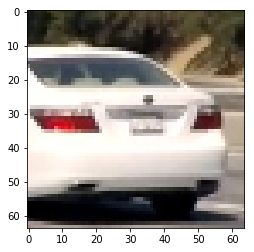

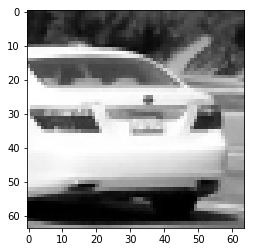

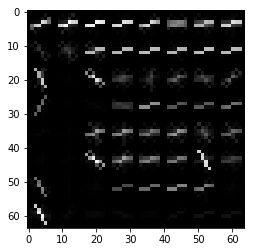

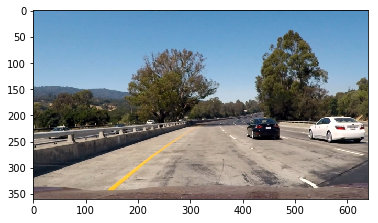

In [439]:
# test images
#('y dimensions ', 512, 576)
#('x dimensions ', 1216, 1280)

#plotting viz
#('y dimensions ', 448, 512)
#('x dimensions ', 576, 640)

#plotting viz
#('y dimensions ', 64, 128)
#('x dimensions ', 0, 64)


#plotting viz
#('y dimensions ', 192, 256)
#('x dimensions ', 0, 64)

hog_params = {'orient' : 9,
'pix_per_cell' : 8,
'cell_per_block' : 2,
'vis':True,
'feature_vec': False}

dir_name = '/Users/davidwoo/Documents/Projects/kitt-playlabs/udacity/CarND-Vehicle-Detection-master/test_images/'
file_name = 'test1.jpg'

img = mpimg.imread(dir_name + file_name)

# use this as a hack to increase sliding window
img_scale = 0.5

img = cv2.resize(img,(int(img.shape[1]*img_scale),int(img.shape[0]*img_scale)))
print("img size", img.shape)
fig4 = plt.figure()
plt.imshow(img)

# 1. Crop image
# sky
#y_start_stop = (64,128)
#x_start_stop = (0,64)

# barrier
# 1. Crop image
y_start_stop = (192,256)
x_start_stop = (0,64)

# car, angle 1, scale = 0.5
# 1. Crop image
y_start_stop = (192,256)
x_start_stop = (576,640)

# car, angle 2, scale = 0.5
# 1. Crop image
#y_start_stop = (192,256)
#x_start_stop = (512,576)

# car, angle 2, scale = 0.25
# 1. Crop image
#y_start_stop = (64,128)
#x_start_stop = (256,320)


# car, angle 2, scale = 0.875
# 1. Crop image
#y_start_stop = (350,414)
#x_start_stop = (992,1056)


#y_start_stop = (448,512)
#x_start_stop = (576,640)

#y_start_stop = (384,576)
#x_start_stop = (1088,1280)

img_filter = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1],:]
plt.imshow(img_filter)
gray = cv2.cvtColor(img_filter,cv2.COLOR_RGB2GRAY)

fig = plt.figure()
plt.imshow(gray, cmap='gray')

hog_channel = 'ALL'

#hog_channel = 0

# 2. Extract features
if hog_channel == 'ALL':
    hog_features = []
    for channel in range(img_filter.shape[2]):
        hog_features.append(get_hog_features(img_filter[:,:,channel], 
                                    feature_params['orient'], feature_params['pix_per_cell'],
                                    feature_params['cell_per_block'], vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)
else:
    hog_features = get_hog_features(gray,**hog_params)

    #hog_features_viz = hog_features[1]
    hog_features = hog_features[0]

print("hog_features shape", hog_features.shape)

# 3. Predict
#win_hog_features = hog_features.ravel()
win_hog_features = hog_features
slide_window_np_scaled = scaler.transform(np.array(win_hog_features).reshape(1, -1))

# plot features
fig2 = plt.figure()
plt.imshow(hog_features_viz, cmap='gray')

print(clf.predict(slide_window_np_scaled))
# it shows false. 

print(clf.predict(slide_window_np_scaled) == 1)


fig4 = plt.figure()
plt.imshow(img)
